In [151]:
# Imports probably done somewhere else 
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, quantum_info as qi

from IPython.display import Markdown
import numpy as np

from utils import array2latex, ket

# Single Qubit Operations
We have defines some states like $\ket{0}$, $\ket{1}$, $\ket{+}$, and $\ket{-}$, but we need a way to create and manipulate them on a quantum computer. We can do this using quantum logic gates.

**Quantum Logic Gates** define operations that change the state of one or more qubits.
These gates from the basis of quantum computing in the same way that binary logic gates (NOT, AND, OR, etc.) for the basis of classical computing.

## Why we need of Single (Qu)bit Logic
Single (qu)bit operations are critical because the let us initialize states and switch between then during computation.

In **Classical Computing** binary bits are deterministic and can only ever be in one (and only one) of two states: `0` or `1`.
Thus we can change between all states with a single Not-Gate which applies the `NOT` ($\neg$) operation to convert $\neg$`0`$\rightarrow$`1` and $\neg$`1`$\rightarrow$`0`.

In [152]:
# Some classical boolean logic
bit_0 = False # `Binary value of `0`
bit_1 = True # Binary value of `1`

display(Markdown(f"`not` `{bit_0}` = `{not bit_0}`"))
display(Markdown(f"`not` `{bit_1}` = `{not bit_1}`"))

`not` `False` = `True`

`not` `True` = `False`

Because classical logic is so simple we hardly talk about single bit operations.

But in **Quantum Computing** each Qubit is a probabilistic superposition of $\ket{0}$ and $\ket{1}$ that will only collapse into `0` or `1` when measured. There are infinitely many qubit states; and thus changing between them requires a far more diverse bases of gates to define a wider set of operations.

Because there are so many states, it is not feasible to consider what a given quantum gates does to all of them; instead we will build an intuition of the _operation_ that gates perform and how they transforms qubit values by moving them along the surface of the Bloch sphere through a series of rotations.


## Properties of Quantum Operations 

Recall that wre describe qubits as a superposition of two states:
$$
\ket{\psi}=\alpha\ket{0}+\beta\ket{1}=\alpha
\begin{bmatrix}
    1\\0
\end{bmatrix}
+\beta
\begin{bmatrix}
    0\\1
\end{bmatrix}
=\begin{bmatrix}
    \alpha\\\beta
\end{bmatrix}
$$
Coefficients $\alpha$ and $\beta$ are complex values where $|\alpha|^2=\alpha\alpha^*$ and $|\beta|^2=\beta\beta^*$ are the probabilities of measuring `0` and `1` respectively.

We can then describe single qubit operation (gate) as a $2\times2$ complex matrix operator $U$ and apply it through mutilation:
$$
\ket{\psi'}=
\begin{bmatrix}
    \alpha'\\\beta'
\end{bmatrix}
= \begin{bmatrix}
    U_{0,0} & U_{0,1} \\
    U_{1,0} & U_{1,1}
\end{bmatrix}
\begin{bmatrix}
    \alpha\\\beta
\end{bmatrix}
=U\ket{\psi}
$$

**Note:** The indexing used for matrix values here matches how you would access them in `python`. For example $U_{1,0}$ is `u[1,0]`

Given that qubits are essentially probability distributions, the matrix operator $U$ is valid if, and only if, **probity is conserved**.

<details>
<summary> 
    <b>How do we know that potability is preserved?</b>
</summary>

Mathematically $|\alpha'|^2+|\beta'|^2=1$ because this ensures that the total probability measuring `0` $\cup$ `1` must unitary (total = 1)

Geometrically the new value $\ket{\psi'}$ must be on the surface of the Bloch sphere (Euclidean Norm of 1) to be valid.

</details>
&nbsp;
<details>
<summary> 
    <b>What does this imply about the quantum operator matrix?</b>
</summary>

It must  _Unitary_.

That is: $U^\dagger U = UU^\dagger=\mathbb{I}$ were $U^\dagger$ denotes the Hermitian Adjoint (complex conjugate) and $\mathbb{I}$ is the identity matrix.

This also means that quantum gates are **reversible** and that **we cannot make a gate to copy qubits**

Notably unitary matrices preserve the probability distribution and the magnitude of the Bloch vector.
This means that all single qubit operations can be fully described by a series of rotations around the Bloch sphere.

</details>


### Practical Investigation (Fiddle)

Let's mess around a bit to convince ourselves that operator matrices must be unitary.

We will start by making a function that returns `True` if the state vector it is given is a valid probability distribution.

In [153]:
def is_valid_ket(state_vector)->bool:
    """Returns `True` if the given state vector (ket) has a valid probability distribution."""

    # Check that the sum of square coefficient magnitudes is 1.
    return bool(np.sum(np.abs(state_vector)**2) == 1)

# This will also be helpful 
def display_valid_ket(state_vector):
    """Prints a message in `Markdown` to indicate if the given state vector (ket) has a valid probability ditabuition."""
    if is_valid_ket(state_vector):
        display(Markdown("$\\ket{{\\psi}} = " + array2latex(test_ket) +"$ is valid"))
    else:
        display(Markdown("$\\ket{{\\psi}} = " + array2latex(test_ket) +"$ is not valid"))


Now we will test our function out

In [154]:
# Play around with these values. Note that we use 1j for √(-1)
test_ket = np.array([
    [(1/np.sqrt(2))*1j],
    [-0.5+0.5j]
])

if is_valid_ket(test_ket):
    display(Markdown("$\\ket{{\\psi}} = " + array2latex(test_ket) +"$ is valid"))
else:
    display(Markdown("$\\ket{{\\psi}} = " + array2latex(test_ket) +"$ is not valid"))

$\ket{{\psi}} = \begin{bmatrix}
0.7071067811865475j\\ 
(-0.5+0.5j)\\ 
\end{bmatrix}$ is valid

Now we can define the operator $U$ and see what we need to do to make it valid 

In [155]:
# Let's make a nice function to help check matrices are valid
def is_unitary(matrix, matrix_size = 2)->bool:
    """Returns `True` is the given complex matrix is unitary"""

    hematin_adjoint = matrix.conjugate().transpose()
    mat_product = np.round(matrix.dot(hematin_adjoint), decimals=15) # round values to account for floating pt. errors
    mat_product_reverse = np.round(hematin_adjoint.dot(matrix), decimals=15)
    
    return bool((mat_product == np.eye(matrix_size)).all() and (mat_product_reverse == np.eye(matrix_size)).all())

In [156]:
# Construct the matrix operator
# Play around with the values to see what works
U_matrix = np.array([
    [1,0],
    [0,1j]], dtype=np.complex128)

# Does forcing the Euclidean norm of each row and/or column ensure a unitary matrix?
# (Uncomment to find out)

# > Normalize rows
# U_matrix[0,:] /= np.sqrt(np.sum(np.abs(U_matrix[0,:])**2))
# U_matrix[1,:] /= np.sqrt(np.sum(np.abs(U_matrix[1,:])**2))

# > Normalize columns
# U_matrix[:,0] /= np.sqrt(np.sum(np.abs(U_matrix[:,0])**2))
# U_matrix[:,1] /= np.sqrt(np.sum(np.abs(U_matrix[:,1])**2))


hematin_adjoint = U_matrix.conjugate().transpose()
mat_product = np.round(U_matrix.dot(hematin_adjoint), decimals=15) # round values to account for floating pt. errors
mat_product_reverse = np.round(hematin_adjoint.dot(U_matrix), decimals=15)

display(Markdown(f"$U={array2latex(U_matrix, fmt_str='{:.4f}')} \\hspace{{10pt}} U^\\dagger={array2latex(hematin_adjoint, fmt_str='{:.4f}')}$"))
display(Markdown(f"$UU^\\dagger={array2latex(mat_product, fmt_str='{:.4f}')} \\hspace{{10pt}} U^\\dagger U={array2latex(mat_product_reverse, fmt_str='{:.4f}')}$"))

if is_unitary(U_matrix):
    display(Markdown("The matrix is unitary"))
else:
    display(Markdown("The Matrix is not unitary"))

$U=\begin{bmatrix}
1.0000+0.0000j & 0.0000+0.0000j\\ 
0.0000+0.0000j & 0.0000+1.0000j\\ 
\end{bmatrix} \hspace{10pt} U^\dagger=\begin{bmatrix}
1.0000-0.0000j & 0.0000-0.0000j\\ 
0.0000-0.0000j & 0.0000-1.0000j\\ 
\end{bmatrix}$

$UU^\dagger=\begin{bmatrix}
1.0000+0.0000j & 0.0000+0.0000j\\ 
0.0000+0.0000j & 1.0000+0.0000j\\ 
\end{bmatrix} \hspace{10pt} U^\dagger U=\begin{bmatrix}
1.0000+0.0000j & 0.0000+0.0000j\\ 
0.0000+0.0000j & 1.0000+0.0000j\\ 
\end{bmatrix}$

The matrix is unitary

In [157]:
# Uncomment to set U here if you want to mess about without scrolling up

# test_ket = np.array([
#     [(1/np.sqrt(2))*1j],
#     [-0.5+0.5j]
# ])

# U_matrix = np.array([
#     [1,0],
#     [0,1]], dtype=np.float64)

# Ensure that test can is valid
test_ket /= np.sqrt(np.sum(np.abs(test_ket)**2))

new_state = U_matrix.dot(test_ket)

display(Markdown(f"$\\ket{{\\psi'}}={array2latex(new_state)}={array2latex(U_matrix)}{array2latex(test_ket)}$"))

# Lets display a message to say if everything is valid
message = ""
if is_valid_ket(new_state):
    message += "`new_state` is valid"
else:
    message += "`new_state` is not valid"
if is_unitary(U_matrix):
    message += " because `U_matrix` is unitary."
else:
    message += " because `U_matrix` is unitary."

display(Markdown(message))

$\ket{\psi'}=\begin{bmatrix}
0.7071067811865475j\\ 
(-0.5-0.5j)\\ 
\end{bmatrix}=\begin{bmatrix}
(1+0j) & 0j\\ 
0j & 1j\\ 
\end{bmatrix}\begin{bmatrix}
0.7071067811865475j\\ 
(-0.5+0.5j)\\ 
\end{bmatrix}$

`new_state` is valid because `U_matrix` is unitary.

## A Demonstration of Initialization `Qiskit`

Let's have a look at how single qubit gates can be used for state initialization.
We won't worry about what the gates do for now. 
This is just to get a feel for things.

_We will see how each of these initiations can be done as we learn about the gates._   


When we create a `QuantumCircuit` all qubits are set to $\ket{0}$ by default.

We use the `QuantumCircuit.initialize()` method set them to other ket values $\ket{\psi}$:

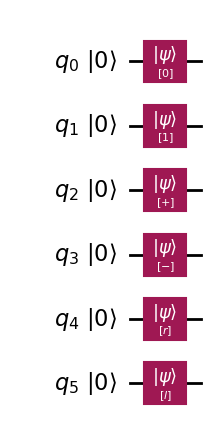

In [158]:
# Make a quantum circuit with 6 qubits
state_demo_qc = QuantumCircuit(6)

state_demo_qc.initialize('0',[0])   # Set first qubit (`q[0]`) to |0> (Note we index form 0) [positive Z-axis]
state_demo_qc.initialize('1',[1])   # Set set `q[1]` to |1> [negative Z-axis]
state_demo_qc.initialize('+',[2])   # Set `q[2]` to |+> [positive X-axis]
state_demo_qc.initialize('-',[3])   # Set `q[3]` |-> [negative X-axis]
state_demo_qc.initialize('r',[4])   # Set `q[4]` to |i> (aka. r or right) [positive Y-axis]
state_demo_qc.initialize('l',[5])   # Set `q[5]` to |-i> (aka. l or left) [negative Y-axis]

# This would do the same thing in one step (but it looks like a big box)
# state_demo_qc.initialize('01+-rl'[::-1],range(6))

# Now display the circuit
state_demo_qc.draw('mpl', initial_state=True)


**Note** While using `initialize()` is the correct approach we can see that it first calls a `reset` gate (the gray ones) followed by a state preparation gate.

These `reset` gates are unnessary since all our qubits start at $\ket{0}$. More problematically the `reset` gates make is so we cannot inspect the matrix operators in `qiskit` so we may use `prepare_sate` instead.
This method works in exactly the same way but doesn't introduce the `reset`.

Now we can visualize the new qubit states on Bloch spheres.

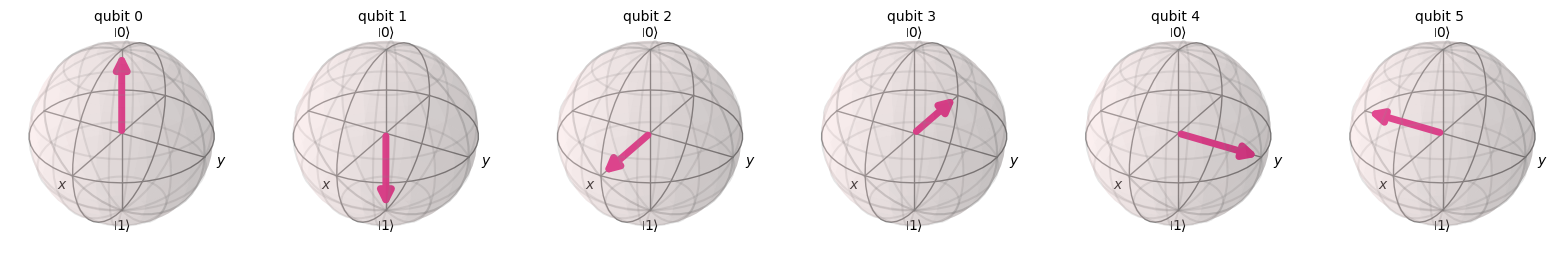

In [ ]:
# Display the quantum circuit 
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

# Get the final state vector of our quantum circuit 
state = Statevector(state_demo_qc)

# Plot the state vector on Bloch spheres
display(plot_bloch_multivector(state))

A Reminder of our initialized values

| **Qubit** | 0 | 1 | 2 | 3 | 4 | 5 |
|---|:-:|:-:|:-:|:-:|:-:|:-:|
| **Set Value** | $\ket{0}$ | $\ket{1}$ | $\ket{+}$ | $\ket{-}$ | $\ket{i}$ | $\ket{-i}$ | 
| **Axis** | Z | Z | X | X | Y | Y |
| **+/-** | + | - | + | - | + | - |

We can already see that all these initializations simply rotate $\ket{0}$ around the Bloch sphere.
But let's quickly sanity check ourselves by verifying that this state vector for this circuit is a valid probability distribution implying that the transmission matrix is unitary.

In [160]:
# Get the out state vector if circuit input is |0> for all qubits
state = Statevector(state_demo_qc)
print(f"The state is valid: {is_valid_ket(state)}")

The state is valid: True


## The Pauli Gates (X, Y & Z Gates)
Now that we know how gates work it's time to learn about some common quantum gates.

The Pauli X, Y, and Z gates are operations that rotate a single qubit $180^\circ$ ($\pi$ radians) around the corresponding X, Y, or Z axis of the Bloch sphere.

For now we will consider how these gates impact the state $\ket{0}$, the initial value of every qubit in `qiskit`.

### The X-Gate (Quantum `not`)

The Pauli X-gate corresponds to a rotation around the x-axis. This means it will flip state $\ket{0}$ to state $\ket{1}$ and visa versa making it analogous to a classical `not` operation.

#### Algebraic Description

Recall that we have:
$
\ket{0}=
\begin{bmatrix}
    1 \\
    0 \\
\end{bmatrix}
$
and
$
\ket{1}=
\begin{bmatrix}
    0 \\
    1 \\
\end{bmatrix}
$

**Exercise**

Try set `U_matrix` to be the X-gate operator that will translate between these two matrices:

In [192]:
# Change this form the identify matrix to your guess for the X-gate TM
X_matrix = np.array([
    [1, 0],
    [0, 1]
])

ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])

display(Markdown(f"${array2latex(X_matrix)}{array2latex(ket_0)}={array2latex(X_matrix.dot(ket_0))}$ Target: $\\ket{{1}}={array2latex(ket_1)}$"))
display(Markdown(f"${array2latex(X_matrix)}{array2latex(ket_1)}={array2latex(X_matrix.dot(ket_1))}$ Target: $\\ket{{0}}={array2latex(ket_0)}$"))

if np.all(X_matrix.dot(ket_0) == ket_1):
    display(Markdown("The matrix is correct!"))
else:
    display(Markdown("Not quite, try another matrix."))
    if not is_unitary(X_matrix):
        display("Note your `Z_matrix` is not unitary.")

$\begin{bmatrix}
1 & 0\\ 
0 & 1\\ 
\end{bmatrix}\begin{bmatrix}
1\\ 
0\\ 
\end{bmatrix}=\begin{bmatrix}
1\\ 
0\\ 
\end{bmatrix}$ Target: $\ket{1}=\begin{bmatrix}
0\\ 
1\\ 
\end{bmatrix}$

$\begin{bmatrix}
1 & 0\\ 
0 & 1\\ 
\end{bmatrix}\begin{bmatrix}
0\\ 
1\\ 
\end{bmatrix}=\begin{bmatrix}
0\\ 
1\\ 
\end{bmatrix}$ Target: $\ket{0}=\begin{bmatrix}
1\\ 
0\\ 
\end{bmatrix}$

Not quite, try another matrix.

<details>
<summary><b>Answer</b></summary>

The transfer matrix for the Z gate is:
$$
X=\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
$$

This simply swaps the values of the two basis vectors $\ket{0}$ and $\ket{1}$

</details>

#### Using X-gates in `qiskit`

We can add X gates to our quantum circuit `qc` using the `QuantumCircuit.x()` method.

We would expect this X-gate to change $q_1$ to $\ket{1}$. To confirm this we can set $q_0$ to $\ket{1}$ and checking that the qubit Bloch spheres match.

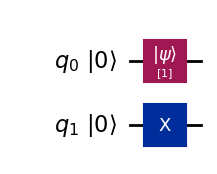

In [193]:
qc = QuantumCircuit(2)

# Add a Pauli X-gate to q_1
qc.x(qubit=1)

# Initialize q_0 to |1>
qc.initialize('1', [0])

qc.draw('mpl', initial_state=True)

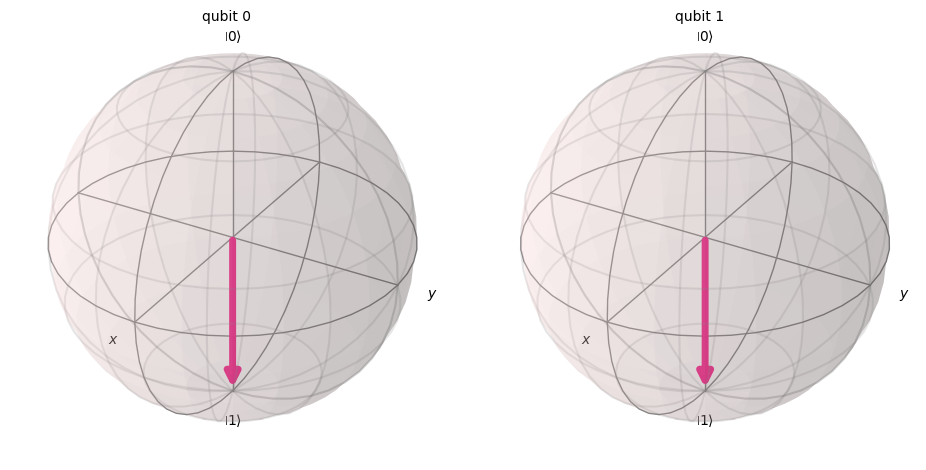

In [194]:
# Plot state vector on Bloch sphere
state = Statevector(qc)
plot_bloch_multivector(state)

In fact to set $\ket{1}$ qiskit is just using X-gates.

We can show this by decomposing the initialization:

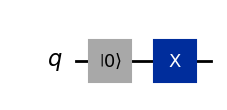

In [197]:
qc = QuantumCircuit(1)
qc.initialize('1',[0])
qc.decompose(reps=2).draw('mpl')

**Question:**

What will happen when we apply the X gate to other common qubit values?

$$
\ket{+}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\1\end{bmatrix}
\hspace{15pt}
\ket{-}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\-1\end{bmatrix}
\hspace{15pt}
\ket{+i}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\ i\end{bmatrix}
\hspace{15pt}
\ket{-i}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\-i\end{bmatrix}
$$

_Think about where they sit on the Bloch sphere... what would happen to kets that are parallel to the X-axis?_

Let's find out by applying the gates in qiskit:
(Try predict it before running the code)

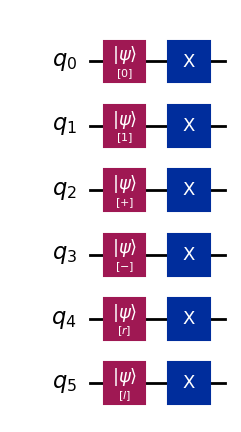

Before: 

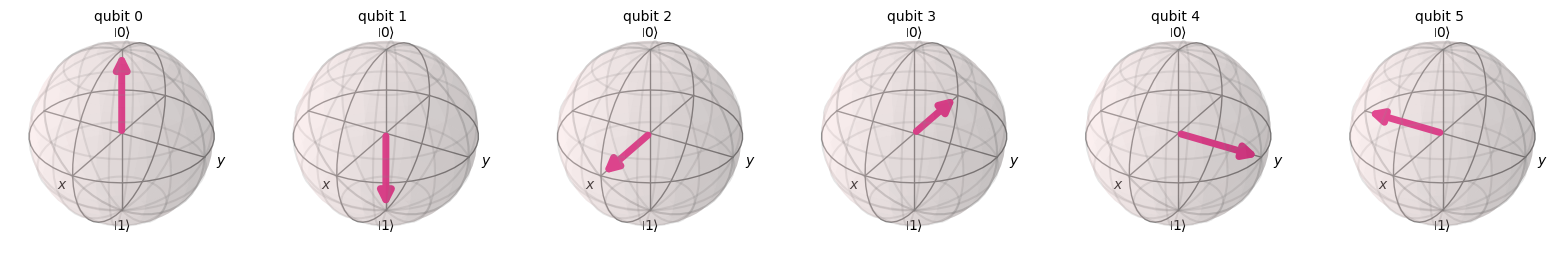

After X-Gate: 

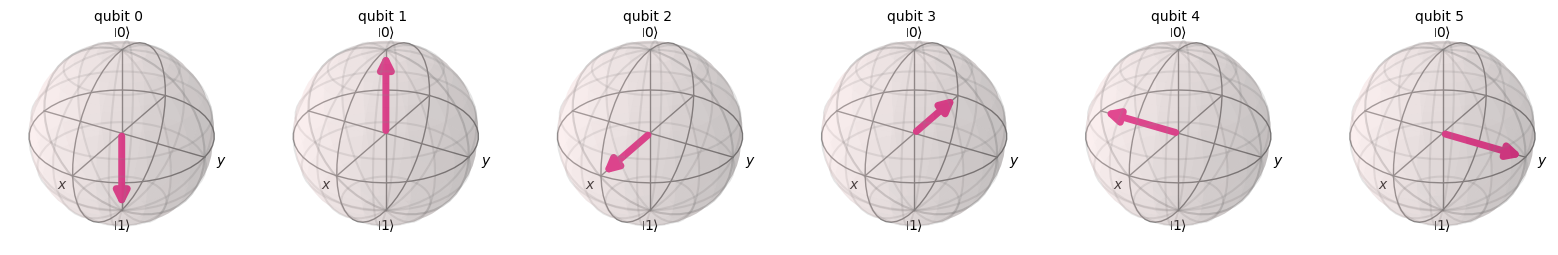

In [ ]:
# Copy the qc where we initalize states
state_qc_x = state_demo_qc.copy()
state_qc_x.x(range(0,6)) # Apply X gate to all qubits

display(state_qc_x.draw('mpl'))

display(Markdown("Before: "))
display(plot_bloch_multivector(Statevector(state_demo_qc)))

display(Markdown("After X-Gate: "))
display(plot_bloch_multivector(Statevector(state_qc_x)))

| **Qubit** | 0 | 1 | 2 | 3 | 4 | 5 |
|---|:-:|:-:|:-:|:-:|:-:|:-:|
| **Set Value** | $\ket{0}=\begin{bmatrix}1\\0\end{bmatrix}$ | $\ket{1}=\begin{bmatrix}0\\1\end{bmatrix}$ | $\ket{+}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\1\end{bmatrix}$ | $\ket{-}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\-1\end{bmatrix}$ | $\ket{i}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\i\end{bmatrix}$ | $\ket{-i}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\-i\end{bmatrix}$ | 
| **Axis** | Z | Z | X | X | Y | Y |
| **After X-Gate** | $\ket{1}=\begin{bmatrix}0\\1\end{bmatrix}$ | $\ket{0}=\begin{bmatrix}1\\0\end{bmatrix}$ | $\ket{+}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\1\end{bmatrix}$ | $\ket{-}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\-1\end{bmatrix}$ | $\ket{-i}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\-i\end{bmatrix}$ | $\ket{i}=\frac{1}{\sqrt{2}}\begin{bmatrix}1\\i\end{bmatrix}$ | 
| Change | Yes | Yes | No | No | Yes | Yes |

#### Let's quickly confirm algebraically by applying matrix operations

**Note:** In qunatum computing: $\begin{bmatrix}-\alpha\\\beta\end{bmatrix} \equiv \begin{bmatrix}\alpha\\-\beta\end{bmatrix}$ due to phase kickback

In [217]:
from qiskit.quantum_info import Operator
qc_x = QuantumCircuit(1)
qc_x.x(0)
X_operator = Operator(qc_x).data # Get the quantum circuit operator and convert it to a `numpy` array
assert isinstance(X_operator, np.ndarray)

kets = {
    '0': np.array([[1],[0]]),
    '1': np.array([[0],[1]]), #ket 1
    '+': (1/np.sqrt(2))*np.array([[1],[1]]), #ket +
    '-': (1/np.sqrt(2))*np.array([[1],[-1]]), #ket -
    'i': (1/np.sqrt(2))*np.array([[1],[1j]]), #ket +
    '-i': (1/np.sqrt(2))*np.array([[1],[-1j]]), #ket -
}

for label, ket in kets.items():
    result = X_operator.dot(ket)
    display(Markdown(f"$U_{{x}}\\ket{{{label}}}={array2latex(X_operator, fmt_str="{:.2f}")}{array2latex(ket, fmt_str="{:.2f}")}={array2latex(result,fmt_str="{:.2f}")}$"))

$U_{x}\ket{0}=\begin{bmatrix}
0.00+0.00j & 1.00+0.00j\\ 
1.00+0.00j & 0.00+0.00j\\ 
\end{bmatrix}\begin{bmatrix}
1.00\\ 
0.00\\ 
\end{bmatrix}=\begin{bmatrix}
0.00+0.00j\\ 
1.00+0.00j\\ 
\end{bmatrix}$

$U_{x}\ket{1}=\begin{bmatrix}
0.00+0.00j & 1.00+0.00j\\ 
1.00+0.00j & 0.00+0.00j\\ 
\end{bmatrix}\begin{bmatrix}
0.00\\ 
1.00\\ 
\end{bmatrix}=\begin{bmatrix}
1.00+0.00j\\ 
0.00+0.00j\\ 
\end{bmatrix}$

$U_{x}\ket{+}=\begin{bmatrix}
0.00+0.00j & 1.00+0.00j\\ 
1.00+0.00j & 0.00+0.00j\\ 
\end{bmatrix}\begin{bmatrix}
0.71\\ 
0.71\\ 
\end{bmatrix}=\begin{bmatrix}
0.71+0.00j\\ 
0.71+0.00j\\ 
\end{bmatrix}$

$U_{x}\ket{-}=\begin{bmatrix}
0.00+0.00j & 1.00+0.00j\\ 
1.00+0.00j & 0.00+0.00j\\ 
\end{bmatrix}\begin{bmatrix}
0.71\\ 
-0.71\\ 
\end{bmatrix}=\begin{bmatrix}
-0.71+0.00j\\ 
0.71+0.00j\\ 
\end{bmatrix}$

$U_{x}\ket{i}=\begin{bmatrix}
0.00+0.00j & 1.00+0.00j\\ 
1.00+0.00j & 0.00+0.00j\\ 
\end{bmatrix}\begin{bmatrix}
0.71+0.00j\\ 
0.00+0.71j\\ 
\end{bmatrix}=\begin{bmatrix}
0.00+0.71j\\ 
0.71+0.00j\\ 
\end{bmatrix}$

$U_{x}\ket{-i}=\begin{bmatrix}
0.00+0.00j & 1.00+0.00j\\ 
1.00+0.00j & 0.00+0.00j\\ 
\end{bmatrix}\begin{bmatrix}
0.71+0.00j\\ 
0.00-0.71j\\ 
\end{bmatrix}=\begin{bmatrix}
0.00-0.71j\\ 
0.71+0.00j\\ 
\end{bmatrix}$

### The Y gate
Now let's look at the Y-gate which does a $\pi$ rad rotation about the Y-axis

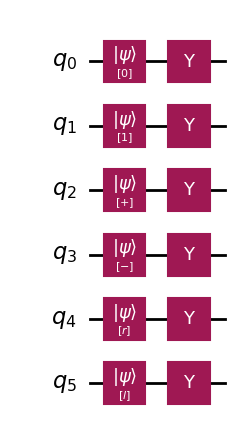

Before: 

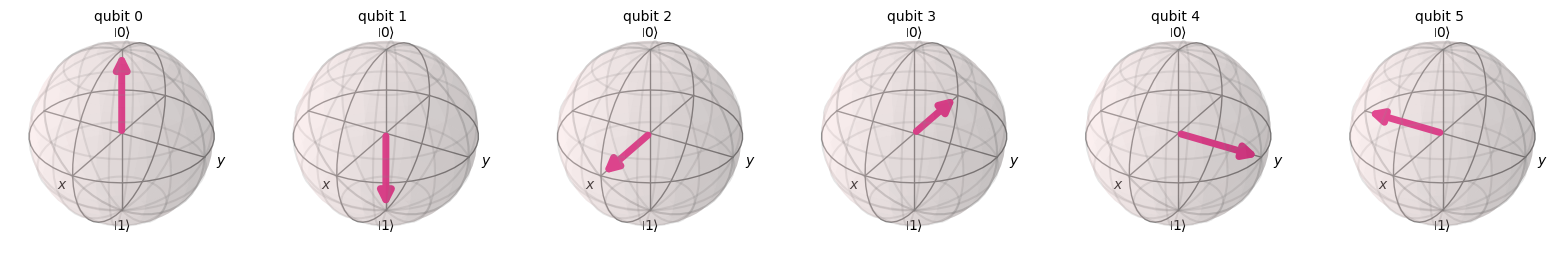

After Y-Gate: 

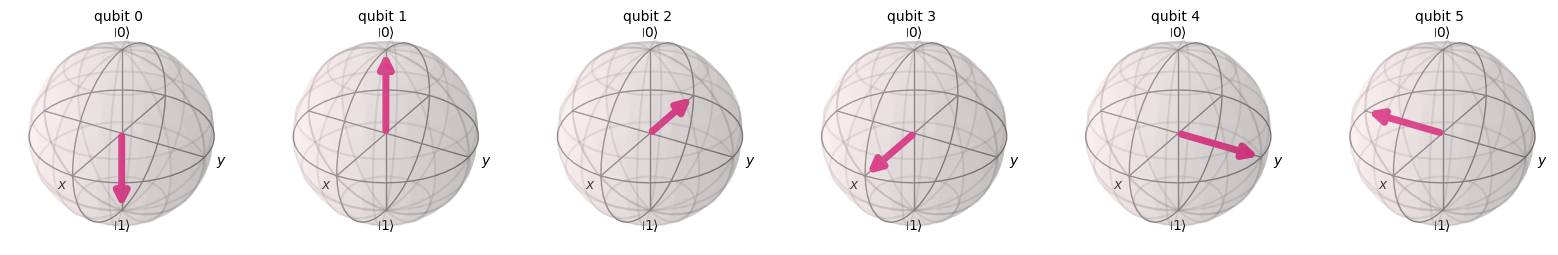

In [220]:
# Copy the qc where we initalize states
state_qc_y = state_demo_qc.copy()
state_qc_y.y(range(0,6)) # Apply X gate to all qubits

display(state_qc_y.draw('mpl'))

display(Markdown("Before: "))
display(plot_bloch_multivector(Statevector(state_demo_qc)))

display(Markdown("After Y-Gate: "))
display(plot_bloch_multivector(Statevector(state_qc_y)))

Do the Does the Y gate do the same thing for 1 and 0?



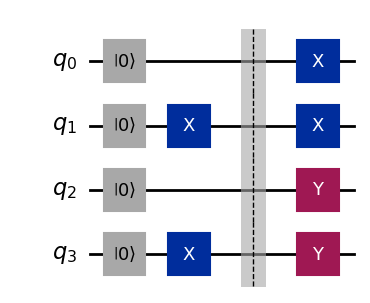

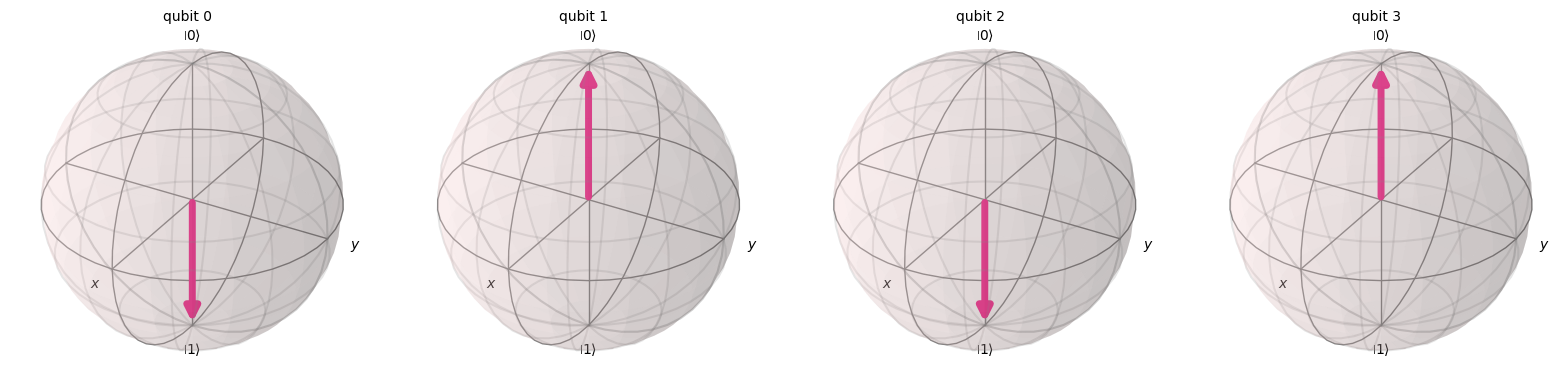

In [ ]:
# Put your code here

<details>

```python
test_qc = QuantumCircuit(4)
test_qc.initialize('0101'[::-1], [0,1,2,3])
test_qc = test_qc.decompose(reps=2)
test_qc.barrier()
test_qc.x(range(0,2))
test_qc.y(range(2,4))

display(test_qc.draw('mpl'))

display(plot_bloch_multivector(Statevector(test_qc)))
```

</details>

In [201]:
qc = QuantumCircuit(1)
qc.initialize('l',[0])

Statevector(qc)

Statevector([0.70710678+0.j        , 0.        -0.70710678j],
            dims=(2,))


In [218]:
qc = QuantumCircuit(1)
qc.y(0)

Operator(qc)

Operator([[0.+0.j, 0.-1.j],
          [0.+1.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))


## The Classical Not Gate

In [164]:
ket = qi.Statevector(qc)
ket

Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [165]:
ket0 = qi.Statevector([1,0])
ket0

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


\begin{equation}
2=1
\end{equation}